In [22]:
import numpy as np
import cv2
import time
import matplotlib.pyplot as plt

img_left_color=cv2.imread('Left/ImageL1.png')
img_right_color=cv2.imread('Right/ImageR1.png')

In [23]:
img_left_bw = cv2.blur(cv2.cvtColor(img_left_color, cv2.COLOR_RGB2GRAY),(5,5))
img_right_bw = cv2.blur(cv2.cvtColor(img_right_color, cv2.COLOR_RGB2GRAY),(5,5))

In [24]:
import numpy as np
import cv2

# Filtering
kernel = np.ones((3, 3), np.uint8)

# Termination criteria
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
criteria_stereo = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

# Prepare object points
objp = np.zeros((8 * 6, 3), np.float32)
objp[:, :2] = np.mgrid[0:8, 0:6].T.reshape(-1, 2)

# Arrays to store object points and image points from all images
objpoints = []  # 3d points in real world space
imgpointsR = []  # 2d points in image plane
imgpointsL = []

# Start calibration from the camera
print('Starting calibration for the 2 cameras... ')
# Call all saved images
for i in range(0, 76):  # Put the amount of pictures you have taken for the calibration inbetween range(0,?) wenn starting from the image number 0
    #print(i)
    t = str(i)
    ChessImaR = cv2.imread('Right/chessboard-R' + t + '.png', 0)  # Right side
    ChessImaL = cv2.imread('Left/chessboard-L' + t + '.png', 0)  # Left side
    retR, cornersR = cv2.findChessboardCorners(ChessImaR, (8, 6),None)  # Define the number of chees corners we are looking for
    retL, cornersL = cv2.findChessboardCorners(ChessImaL, (8, 6), None)  # Left side
    if (True == retR) & (True == retL):
        objpoints.append(objp)
        cornersR = cv2.cornerSubPix(ChessImaR, cornersR, (11, 11), (-1, -1), criteria)
        cornersL = cv2.cornerSubPix(ChessImaL, cornersL, (11, 11), (-1, -1), criteria)
        imgpointsR.append(cornersR)
        imgpointsL.append(cornersL)

#   Right Side
retR, mtxR, distR, rvecsR, tvecsR = cv2.calibrateCamera(objpoints,
                                                        imgpointsR,
                                                        ChessImaR.shape[::-1], None, None)
hR, wR = ChessImaR.shape[:2]
OmtxR, roiR = cv2.getOptimalNewCameraMatrix(mtxR, distR,
                                            (wR, hR), 1, (wR, hR))

#   Left Side
retL, mtxL, distL, rvecsL, tvecsL = cv2.calibrateCamera(objpoints,
                                                        imgpointsL,
                                                        ChessImaL.shape[::-1], None, None)
hL, wL = ChessImaL.shape[:2]
OmtxL, roiL = cv2.getOptimalNewCameraMatrix(mtxL, distL, (wL, hL), 1, (wL, hL))

# StereoCalibrate function
flags = 0
flags |= cv2.CALIB_FIX_INTRINSIC
retS, MLS, dLS, MRS, dRS, R, T, E, F = cv2.stereoCalibrate(objpoints,
                                                           imgpointsL,
                                                           imgpointsR,
                                                           mtxL,
                                                           distL,
                                                           mtxR,
                                                           distR,
                                                           ChessImaR.shape[::-1],
                                                           criteria_stereo,
                                                           flags)

# StereoRectify function
rectify_scale = 0  # if 0 image croped, if 1 image nor croped
RL, RR, PL, PR, Q, roiL, roiR = cv2.stereoRectify(MLS, dLS, MRS, dRS,
                                                  ChessImaR.shape[::-1], R, T,
                                                  rectify_scale,
                                                  (0, 0))  # last paramater is alpha, if 0= croped, if 1= not croped
# initUndistortRectifyMap function
Left_Stereo_Map = cv2.initUndistortRectifyMap(MLS, dLS, RL, PL,
                                              ChessImaR.shape[::-1],
                                              cv2.CV_16SC2)  # cv2.CV_16SC2 this format enables us the programme to work faster
Right_Stereo_Map = cv2.initUndistortRectifyMap(MRS, dRS, RR, PR,
                                               ChessImaR.shape[::-1], cv2.CV_16SC2)


Left1=Left_Stereo_Map[1].reshape((480,640,1))
Left=np.concatenate((Left_Stereo_Map[0],Left1),axis=2)
LFTdata=Left.reshape(Left.shape[0],-1)
Right1=Right_Stereo_Map[1].reshape((480,640,1))
Right=np.concatenate((Right_Stereo_Map[0],Right1),axis=2)
RGTdata=Right.reshape(Right.shape[0],-1)

np.savetxt('Left_Stereo0.txt', LFTdata)
np.savetxt('Right_Stereo0.txt', RGTdata)

Starting calibration for the 2 cameras... 


In [25]:
def showImg(img):
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_RGB2BGR))
    
def write_ply(fn, verts, colors):
    ply_header = '''ply
    format ascii 1.0
    element vertex %(vert_num)d
    property float x
    property float y
    property float z
    property uchar red
    property uchar green
    property uchar blue
    end_header
    '''
    out_colors = colors.copy()
    verts = verts.reshape(-1, 3)
    verts = np.hstack([verts, out_colors])
    with open(fn, 'wb') as f:
        f.write((ply_header % dict(vert_num=len(verts))).encode('utf-8'))
        np.savetxt(f, verts, fmt='%f %f %f %d %d %d ')

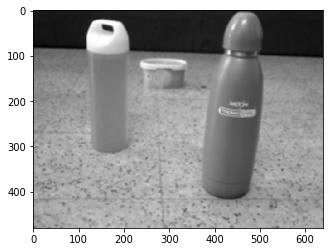

In [26]:
plt.imshow(img_right_bw, cmap='gray')

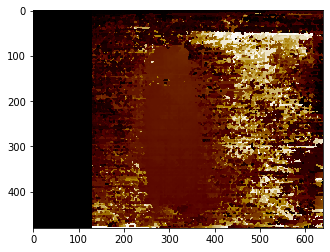

In [27]:
#stereo = cv2.StereoBM_create(numDisparities=96, blockSize=7)
window_size = 3
min_disp = 2
num_disp = 130-min_disp
stereo = cv2.StereoSGBM_create(minDisparity = min_disp,
    numDisparities = num_disp,
    blockSize = window_size,
    uniquenessRatio = 10,
    speckleWindowSize = 100,
    speckleRange = 32,
    disp12MaxDiff = 5,
    P1 = 8*3*window_size**2,
    P2 = 32*3*window_size**2)
# Used for the filtered image
stereoR=cv2.ximgproc.createRightMatcher(stereo) # Create another stereo for right this time
kernel= np.ones((3,3),np.uint8)
# WLS FILTER Parameters
lmbda = 80000
sigma = 0.5
visual_multiplier = 1.0
 
wls_filter = cv2.ximgproc.createDisparityWLSFilter(matcher_left=stereo)
wls_filter.setLambda(lmbda)
wls_filter.setSigmaColor(sigma)

# StereoVision
frameL=cv2.imread('LeftNew/ImageobjectL3.png')
frameR=cv2.imread('RightNew/ImageobjectR3.png')

# Rectify the images on rotation and alignement
Left_nice= cv2.remap(frameL,Left_Stereo_Map[0],Left_Stereo_Map[1], cv2.INTER_LANCZOS4, cv2.BORDER_CONSTANT, 0)  # Rectify the image using the kalibration parameters founds during the initialisation
Right_nice= cv2.remap(frameR,Right_Stereo_Map[0],Right_Stereo_Map[1], cv2.INTER_LANCZOS4, cv2.BORDER_CONSTANT, 0)

grayR = cv2.cvtColor(Right_nice, cv2.COLOR_BGR2GRAY)
grayL = cv2.cvtColor(Left_nice, cv2.COLOR_BGR2GRAY)

# Compute the 2 images for the Depth_image
# Compute the 2 images for the Depth_image
disp= stereo.compute(grayL,grayR)#.astype(np.float32)/ 16
dispL= disp
dispR= stereoR.compute(grayR,grayL)
dispL= np.int16(dispL)
dispR= np.int16(dispR)

# Using the WLS filter
filteredImg= wls_filter.filter(dispL,grayL,None,dispR)
filteredImg = cv2.normalize(src=filteredImg, dst=filteredImg, beta=0, alpha=255, norm_type=cv2.NORM_MINMAX);
filteredImg = np.uint8(filteredImg)
#cv2.imshow('Disparity Map', filteredImg)
disp= ((disp.astype(np.float32)/ 16)-min_disp)/num_disp # Calculation allowing us to have 0 for the most distant object able to detect

##    # Resize the image for faster executions
##    dispR= cv2.resize(disp,None,fx=0.7, fy=0.7, interpolation = cv2.INTER_AREA)

# Filtering the Results with a closing filter
closing= cv2.morphologyEx(disp,cv2.MORPH_CLOSE, kernel) # Apply an morphological filter for closing little "black" holes in the picture(Remove noise) 

# Colors map
dispc= (closing-closing.min())*255
dispC= dispc.astype(np.uint8)                                   # Convert the type of the matrix from float32 to uint8, this way you can show the results with the function cv2.imshow()
disp_Color= cv2.applyColorMap(dispC,cv2.COLORMAP_OCEAN)         # Change the Color of the Picture into an Ocean Color_Map
#filt_Color= cv2.applyColorMap(filteredImg,cv2.COLORMAP_OCEAN) 

# Show the result for the Depth_image
#cv2.imshow('Disparity', disp)
#cv2.imshow('Closing',closing)
#cv2.imshow('Color Depth',disp_Color)
#cv2.imshow('Filtered Color Depth',filt_Color)

#disparity = stereo.compute(img_left_bw,img_right_bw)

img = dispc.copy()
plt.imshow(disp_Color)


In [28]:
calib_matrix_1=np.loadtxt("Left_Stereo0.txt",dtype=np.float32).reshape(3,-1)
calib_matrix_2=np.loadtxt("Right_Stereo0.txt",dtype=np.float32).reshape(3,-1)
print(calib_matrix_2.shape)

(3, 307200)


In [29]:
# Calculate depth-to-disparity
cam1 = calib_matrix_1[:,:3] # left image - P2
cam2 = calib_matrix_2[:,:3] # right image - P3
print(cam1.shape)
Tmat = np.array([0.10, 0., 0.])

rev_proj_matrix = np.zeros((4,4))

cv2.stereoRectify(cameraMatrix1 = cam1,cameraMatrix2 = cam2, \
                  distCoeffs1 = 0, distCoeffs2 = 0, \
                  imageSize = img_left_color.shape[:2], \
                  R = np.identity(3), T = Tmat, \
                  R1 = None, R2 = None, \
                  P1 =  None, P2 =  None, Q = rev_proj_matrix);

(3, 3)


In [30]:
points = cv2.reprojectImageTo3D(img, rev_proj_matrix)

#reflect on x axis
reflect_matrix = np.identity(3)
reflect_matrix[0] *= -1
points = np.matmul(points,reflect_matrix)

#extract colors from image
colors = cv2.cvtColor(img_left_color, cv2.COLOR_BGR2RGB)

#filter by min disparity
mask = img > img.min()
out_points = points[mask]
out_colors = colors[mask]

#filter by dimension
idx = np.fabs(out_points[:,0]) < 4.5
out_points = out_points[idx]
out_colors = out_colors.reshape(-1, 3)
out_colors = out_colors[idx]

write_ply('out.ply', out_points, out_colors)
print('%s saved' % 'out.ply')

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in matmul
  


out.ply saved


In [31]:
print(points.shape)
reflected_pts = np.matmul(out_points, reflect_matrix)
print(np.array([0., 0., 0.]).shape)
projected_img,_ = cv2.projectPoints(reflected_pts, np.array([0., 0., 0.]), np.array([0., 0., 0.]),  cam2[:3,:3], np.array([0., 0., 0., 0.]))
print(projected_img.shape)
#projected_img = projected_img.reshape(-1, 3)


(480, 640, 3)
(3,)
(237875, 1, 2)


In [32]:
blank_img = np.zeros(img_left_color.shape, 'uint8')
img_colors = img_right_color[mask][idx].reshape(-1,3)

for i, pt in enumerate(projected_img):
    pt_x = int(pt[0][0])
    pt_y = int(pt[0][1])
    if pt_x > 0 and pt_y > 0:
        # use the BGR format to match the original image type
        col = (int(img_colors[i, 2]), int(img_colors[i, 1]), int(img_colors[i, 0]))
        cv2.circle(blank_img, (pt_x, pt_y), 1, col)


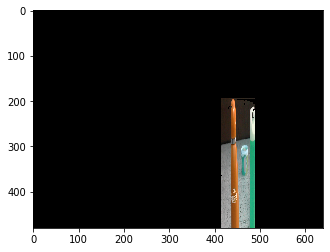

In [33]:
showImg(blank_img)